# OCR Agent from scratch:

* [Data](./Data-Sources.ipynb)
* [Utilities](./Data-Processing.ipynb)
* [Extract layout features and visual tokens](./Data-Extraction-2.ipynb)
* Generate training data
    * [Labeling](./Data-Extraction-3.ipynb)
    * Pipeline
    * [Datasets](./Datasets.ipynb)
* [Model architecture](./Model-Backbone.ipynb)
* [Traversal strategies](./Traversal-Layout.ipynb)
* [Reader Agent](./Agent-LM.ipynb)
* [Leverage synthetic training data](./Data-Gen.ipynb)
* [Optimization for production](./Optimization.ipynb)


### Put together extraction with labeling pipeline

* Load the image
* Extract layout and text features
* Match labels using `pdf` data
* Filter out data with uncertain labels

In [1]:
import torch
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from collections import Counter
from unidecode import unidecode
from torch.utils.data import DataLoader, Dataset

In [2]:
from scripts.extract import *

In [3]:
samples = sorted([str(x)[12:-4] for x in Path('./data/images').glob('*.png')])
len(samples)

8631

    done = set([str(x)[13:-7] for x in Path('./data/extract').glob('*.csv.gz')])
    samples = [x for x in samples if not x in done]
    # get some reasonable size for first try
    samples = np.random.choice(samples, 2000, replace=False)

In [4]:
def main(source):    
    image = load_image(source)
    if np.min(image) == 255:
        return
    objects = extract_layout(image)
    if objects is None:
        return
    
    tokens, words, lines, boxes, success = objects    
    # remove duplicates
    tokens['index'] = None
    run_checkup(tokens, image)
    tokens = tokens.loc[tokens['index']!=-1,:].drop('index', axis=1)    
    # set center-point reference for matching label
    tokens['level'] = (tokens['top'] + tokens['height']//2).astype(int)
    tokens['order'] = (tokens['left'] + tokens['width']//2).astype(int)
    boxes.loc[:,['block-index','line-index','word-index']] = -1
    boxes['level'] = (boxes['top'] + boxes['height']//2).astype(int)
    boxes['order'] = (boxes['left'] + boxes['width']//2).astype(int)
    # lift center-point for underscore-lines to match the input space
    LN = int(lines['height'].median())
    boxes.loc[boxes['type']==HLINE,'level'] -= LN//2
    tokens = pd.concat([tokens, boxes[tokens.columns]]).set_index(['level','order'])
    # match labels
    words, chars, inputs = load_labels(source, LN)    
    result = run_labeling(tokens, image, words, chars, inputs)
    tokens.loc[:, result.columns] = result.values
    return tokens, success


In [5]:
source = np.random.choice(samples)

tokens, success = main(source)
round(len(tokens[tokens['proba'] > 0.7])/len(tokens), 2), success

(0.88, True)

Some tokens could have multiple representations with the same visual outcome -
let's reduce it to the single label.

[Full list of symbols](https://symbl.cc/en/unicode-table/) 

In [6]:
# in our corput those looks identical
def stem_label(s):
    if s is None:
        return
    if s in '–—−‐':
        return '-'
    if s in '×✗':
        return "x"
    if s in ('CheckBox','RadioButton'):
        return '☐'
    if s in '”“':
        return '"'
    if s in '’‘':
        return "'"
    if s == '●':
        return "•"
    if s == '►':
        return "▶"     
    if s == '◄':
        return "◀"     
    return s


    # clear previous run output
    !rm data/training/*

    labels, result = [], []
    for i, source in enumerate(samples, 1):
        output = main(source)
        if output is None:
            continue
        tokens, success = output
        tokens['label'] = tokens['label'].apply(stem_label)
        # keep only those with reliable label
        proba = tokens['proba'].mean()
        size = len(tokens)
        tokens = tokens.loc[tokens['proba'] > 0.8]
        # save for training
        tokens.to_csv(f'./data/training/{source}.csv.gz', index=False, compression='gzip')
        # get in-doc counts
        count = tokens.groupby('label').size()
        # append to adjusted-in-all
        labels += count.index.tolist()
        #print(f"{i:>4} {source:<20} {len(tokens):<5} {proba:.2%}")
        result.append({'source':  source,
                       'size':    size,
                       'samples': len(tokens),
                       'labels':  len(count),
                       'proba':   proba,
                       'success': success})
        print(f'done: {i/len(samples):<8.2%} proba: {proba:<4.0%} sample: {len(tokens)/size:.0%} ', end='\r')

    labels = pd.DataFrame(Counter(labels).most_common(), columns=['label','count'])
    # separate `char`-level tokens (including CheckBox and Radio)
    labels['len'] = labels['label'].str.len()
    labels = labels.sort_values(['len','count'], ascending=[True, False]).drop('len', axis=1)
    # calculate label weight for training
    labels['weight'] = (1./labels['count']).round(4).values
    index = pd.DataFrame.from_dict(result)
    # set train-test split
    index['test'] = (np.random.rand(len(index)) > 0.9).astype(int)
    len(labels)

    labels.to_csv('./data/training-labels.csv', index=False)

    # --- or if update -----------------------------------------------    
    # update with new samples
    #update = pd.read_csv('./data/training-labels.csv')
    #INDEX  = update['label'].tolist()
    #update = update.merge(labels, on='label', how='outer').fillna(1)
    #update['count'] = update['count_x'] + update['count_y']
    #update['weight'] = (2./update['count']).round(4).values
    #update.set_index('label').loc[INDEX, ['count','weight']].to_csv('./data/training-labels.csv')

    index[['samples','proba','labels']].describe()

    index['filter'] = index.apply(lambda d:d['labels'] >= 16, axis=1)
    index['filter'].sum()

    index = index.loc[index['filter'] > 0].drop('filter', axis=1)
    index.to_csv('./data/training-index.csv', index=False)
    
    # --- or if update -----------------------------------------------    
    # append to another sample from the same corpus
    #index = pd.concat([pd.read_csv('./data/training-index.csv'), index], ignore_index=True)
    #index.to_csv('./data/training-index.csv', index=False)

    filters = (labels['label'].str.len()==1)&(labels['count'] > 1)
    # make an index reference for the `char`-labels appearing in the data
    INDEX = labels[filters]['label'].tolist()
    print(len(INDEX))

    base = set(string.ascii_letters + string.digits)
    len(base.intersection(set(INDEX[:128]))) == len(base)

### `Dataset` class
Characters appearance frequency is very uneven. To make representation more balanced and improve contrast in the batch we build a special dataset class: it implicitly upscales all underrepresented symbols. The `weight` we calculated above applies to this setting: frequency between sources vs. in the full corpus.

In [7]:
labels = pd.read_csv('./data/training-labels.csv')
index = pd.read_csv('./data/training-index.csv')

INDEX = labels[(labels['label'].str.len()==1)&(labels['count'] > 1)]['label'].tolist()
# add space and unknown yet
INDEX = [' '] + INDEX + ['']

In [8]:
class TokenDataset(Dataset):
    def __init__(self, source, labels, proba_threshold=0.8, path='training', amp=1, min_count=1, dim=32):
        self.dim = (dim, dim)
        self.amp = amp
        self.labels = labels
        data = pd.read_csv(f'./data/{path}/{source}.csv.gz')
        filters = (data['label'].isin(self.labels))&(data['proba'] > proba_threshold)
        self.data = data.loc[filters,:]
        index = data[filters].groupby('label').size()
        # having at least `min_count` samples of each
        self.index = np.random.permutation(index[index >= min_count].index.tolist())
        self.image = 255 - load_image(source)
        
    def __len__(self):
        return len(self.index) * self.amp
    
    def clip(self, x, y, w, h):        
        if y < 0:
            y, h = 0, h + y
        clip = self.image[y:y + h,x:x + w]
        s = max(clip.shape)
        square = np.zeros((s, s))
        square[(s - h)//2:(s - h)//2 + clip.shape[0],(s - w)//2:(s - w)//2 + clip.shape[1]] = clip
        return square/255.
    
    def encode(self, label):
        if str(label) in self.labels:
            return self.labels.index(str(label))
        return self.labels.index('') # something new
    
    def get_values(self, idx):
        columns = BOX + ['label','left-side','right-side']
        values = self.data[self.data['label']==self.index[idx//self.amp]].sample()[columns].values[0]
        box, label, neighbors = values[:4], values[4], values[5:]
        return box, label, neighbors

    def __getitem__(self, idx):
        box, label, neighbors = self.get_values(idx)
        x, y, w, h = box
        target = self.clip(x - 1, y - 2, w + 2, h + 4)
        X = torch.Tensor(cv2.resize(target, self.dim, cv2.INTER_AREA)).unsqueeze(0)
        Y = torch.Tensor([self.encode(label)]).long()
        return X, Y
    

Samples: 0q41vdusp,PztANfow8)TgHjV6k☐cbZ.2eam'YlMiWEy39B(xIhnS7rR:-5CF


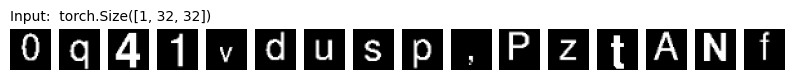

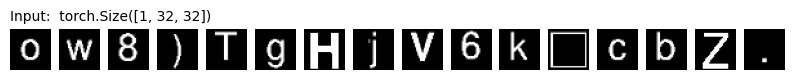

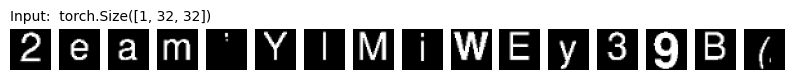

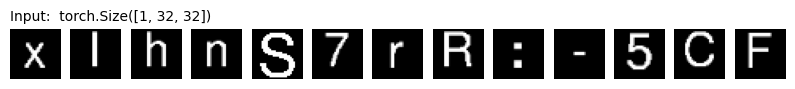

In [9]:
def show_inputs(X, title='Input', size=(10, 10)):
    n = len(X)
    fig, ax = plt.subplots(1, n, figsize=size)
    for i in range(n):
        ax[i].imshow(X[i,:].squeeze().numpy(), 'gray')
        ax[i].axis('off')
    ax[0].set_title(f'{title}:  {X.shape[1:]}', fontsize=10, ha='left', x=0)
    plt.show()
    

source = np.random.choice(index['source'])
D = TokenDataset(source, INDEX)
print('Samples:',''.join(D.index))
for batch in DataLoader(D, batch_size=16):
    if len(batch[0]) > 1:
        show_inputs(batch[0])

We've got a simple token dataset. For the model training we will need [much more](Datasets.ipynb).